<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/time-series-rnn-full-predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Time Series data

* Idea and some code taken from, and also OPSD time series data set explained here: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
* Some code and approaches from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
* Nice tutorial: https://www.tensorflow.org/beta/tutorials/text/time_series

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [0]:
import pandas as pd
import numpy as np

In [0]:
# for local
# url = 'opsd_germany_daily.csv'

# for colab
url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'

time_series_df = pd.read_csv(url, 
                             sep=',', 
                             index_col=0, # you can use the date as the index for pandas
                             parse_dates=[0]) # where is the time stamp?

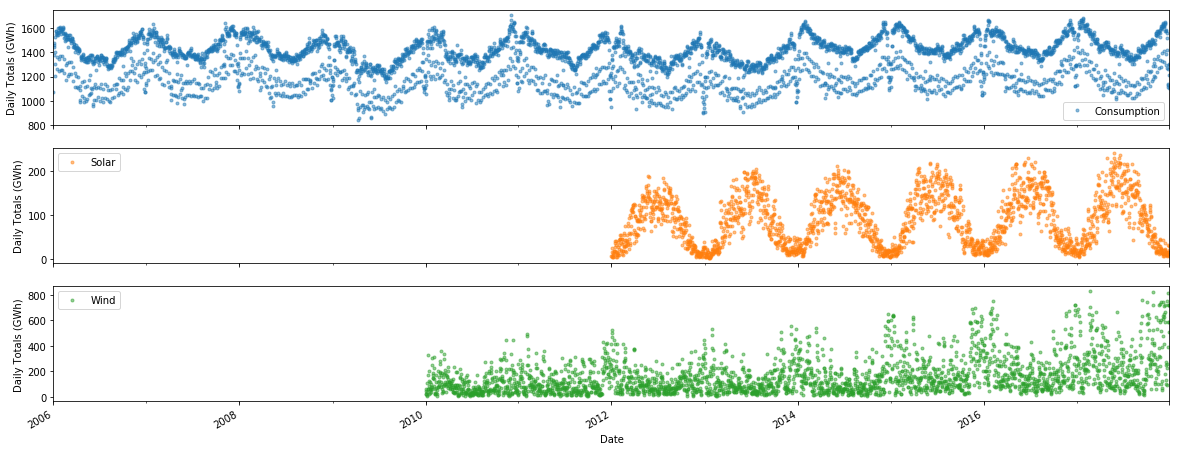

In [4]:
cols_plot = ['Consumption', 'Solar', 'Wind']

axes = time_series_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

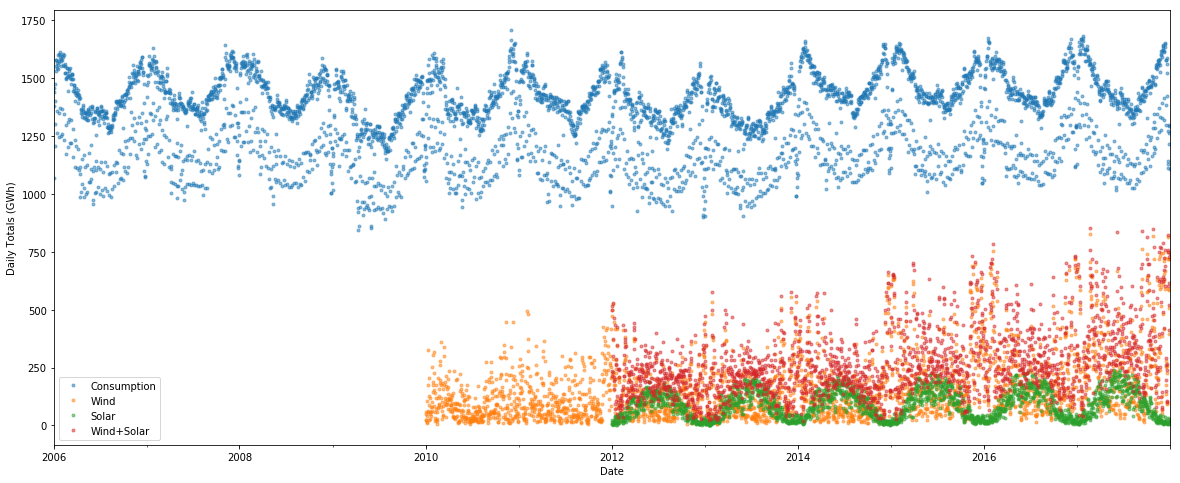

In [5]:
axes = time_series_df.plot(marker='.', alpha=0.5, linestyle='None')
plt.ylabel('Daily Totals (GWh)');

## Can we predict each day's consumption from its past?

### We train on the years 2006 - 2016 and validate on 2017

In [6]:
consumption = time_series_df['Consumption'].to_numpy()
consumption.shape

(4383,)

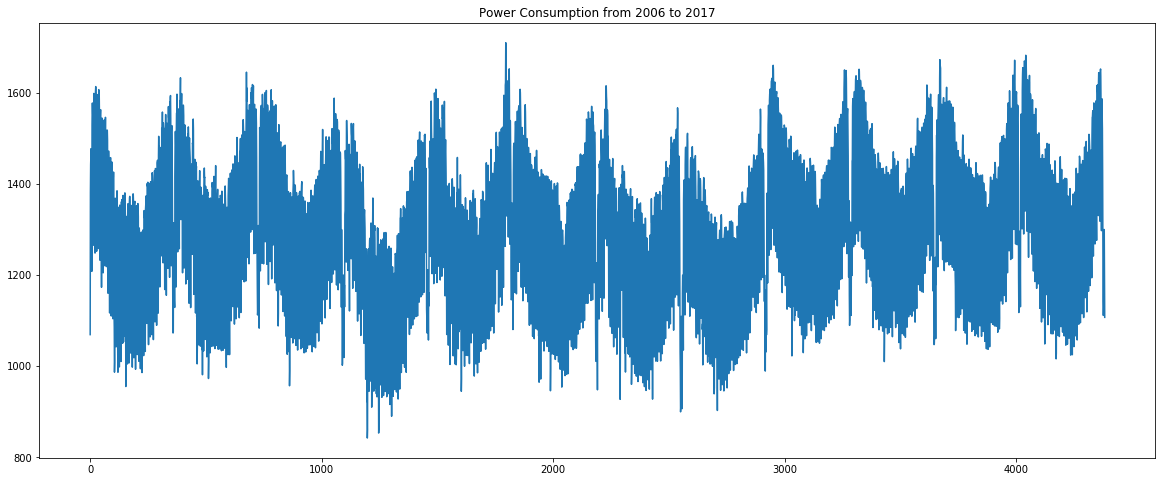

In [7]:
plt.title('Power Consumption from 2006 to 2017')
plt.plot(consumption);

In [0]:
# derived from here: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

### How much of the past would we like for each individual prediction?

In [0]:
#@title Prediction from n days to m days

# https://colab.research.google.com/notebooks/forms.ipynb

n_steps_in = 90 #@param {type:"slider", min:1, max:100, step:1}
n_steps_out = 1

In [10]:
X, Y = split_sequence(consumption, n_steps_in, n_steps_out)
X.shape, Y.shape

((4293, 90), (4293, 1))

In [11]:
X[0], Y[0]

(array([1069.184, 1380.521, 1442.533, 1457.217, 1477.131, 1403.427,
        1300.287, 1207.985, 1529.323, 1576.911, 1577.176, 1553.28 ,
        1545.002, 1359.945, 1265.475, 1563.738, 1598.303, 1572.984,
        1558.29 , 1540.604, 1348.188, 1248.111, 1569.691, 1603.252,
        1613.312, 1601.673, 1586.065, 1373.03 , 1252.215, 1554.722,
        1575.129, 1582.134, 1595.717, 1577.786, 1366.322, 1258.013,
        1557.525, 1606.667, 1590.896, 1599.129, 1554.631, 1346.104,
        1232.568, 1521.456, 1551.373, 1562.656, 1523.719, 1495.913,
        1297.385, 1173.05 , 1501.246, 1544.112, 1543.107, 1523.491,
        1507.235, 1309.603, 1204.766, 1444.899, 1507.49 , 1531.173,
        1539.951, 1510.884, 1323.303, 1220.395, 1502.191, 1514.012,
        1545.834, 1498.444, 1475.327, 1320.368, 1218.407, 1494.832,
        1514.066, 1518.04 , 1516.898, 1495.324, 1280.717, 1160.078,
        1446.238, 1470.34 , 1471.667, 1456.016, 1444.75 , 1231.067,
        1116.743, 1400.982, 1435.152, 1438.405, 

In [12]:
# reshape from [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(4293, 90, 1)

In [13]:
# we do a special test / train split, 
# we see how well we can predict 2017 as test/validation 


X_train = X[:-365]
Y_train = Y[:-365]

X_test = X[-365:]
Y_test = Y[-365:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3928, 90, 1), (3928, 1), (365, 90, 1), (365, 1))

## Prediction using a rolling mean baseline

More or less taken from: https://www.tensorflow.org/tutorials/structured_data/time_series

In [0]:
def rolling_mean_baseline(history):
  return np.mean(history, axis=1)

In [0]:
Y_pred_baseline = rolling_mean_baseline(X)

In [16]:
from sklearn.metrics import r2_score

r2_score(Y, Y_pred_baseline)

0.11171487990598994

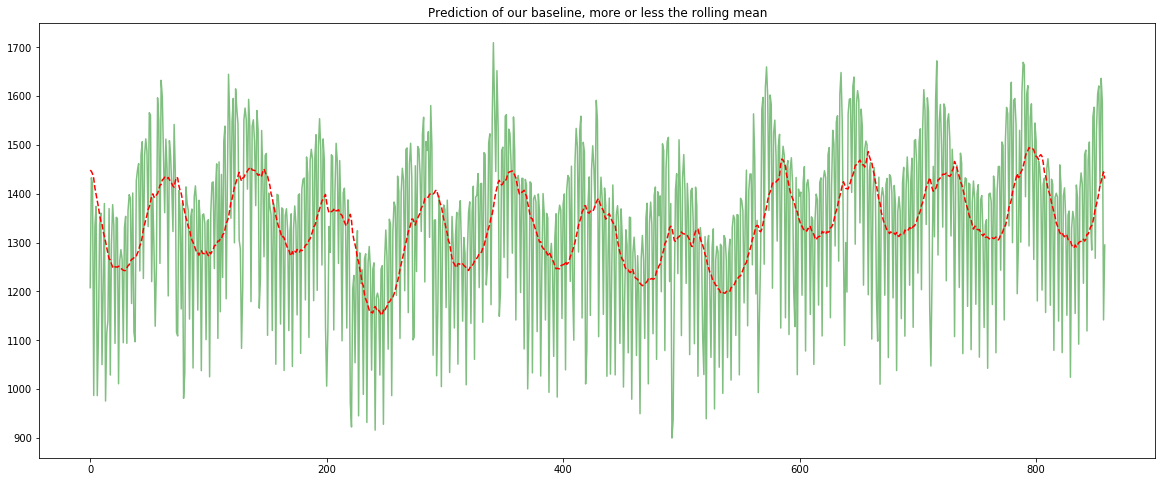

In [17]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(consumption[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline[::stride], color='r', ls='dashed')

plt.title('Prediction of our baseline, more or less the rolling mean');


## Prediction using RNNs and TensorFlow

### Can we beat an r2 score around .12?

In [18]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [19]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc1


In [0]:
# adapted from https://stackoverflow.com/a/42351397/1756489 and ported to TF 2
# https://keras.io/metrics/#custom-metrics

# only works on tensors while training, use sklearn version when using on numpy arrays

def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error))
  
  return R_squared

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

model = Sequential()

# known to work well
model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(GRU(100, activation='relu'))

# next experiment
# model.add(GRU(256, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(GRU(256, activation='relu'))

# optional regularization
# model.add(BatchNormalization())
# model.add(Dropout(0.2))


# combines final outputs from RNN into continous output
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 90, 100)           30900     
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
%%time

batch_size = 32
epochs=15

history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1)

Train on 3928 samples, validate on 365 samples
Epoch 1/15
3928/3928 [==============================] - 44s 11ms/sample - loss: 266194.2399 - r2_metric: -9.9727 - val_loss: 18576.6279 - val_r2_metric: 0.0567
Epoch 2/15
3928/3928 [==============================] - 40s 10ms/sample - loss: 18124.9303 - r2_metric: 0.2875 - val_loss: 17270.2532 - val_r2_metric: 0.1270
Epoch 3/15
3928/3928 [==============================] - 40s 10ms/sample - loss: 17045.3836 - r2_metric: 0.3440 - val_loss: 16042.5742 - val_r2_metric: 0.1870
Epoch 4/15
3928/3928 [==============================] - 39s 10ms/sample - loss: 15723.2304 - r2_metric: 0.3915 - val_loss: 15342.1817 - val_r2_metric: 0.2267
Epoch 5/15
3928/3928 [==============================] - 40s 10ms/sample - loss: 15245.9265 - r2_metric: 0.4036 - val_loss: 16016.1215 - val_r2_metric: 0.1980
Epoch 6/15
3928/3928 [==============================] - 38s 10ms/sample - loss: 14255.4013 - r2_metric: 0.4404 - val_loss: 18901.8214 - val_r2_metric: 0.0309
Epo

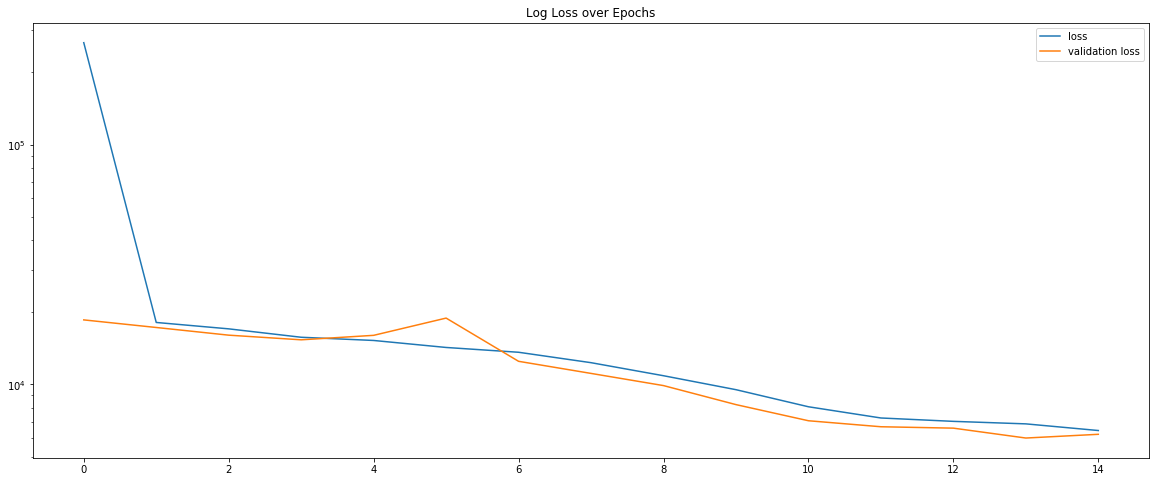

In [23]:
plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Log Loss over Epochs')

plt.legend(['loss', 'validation loss']);

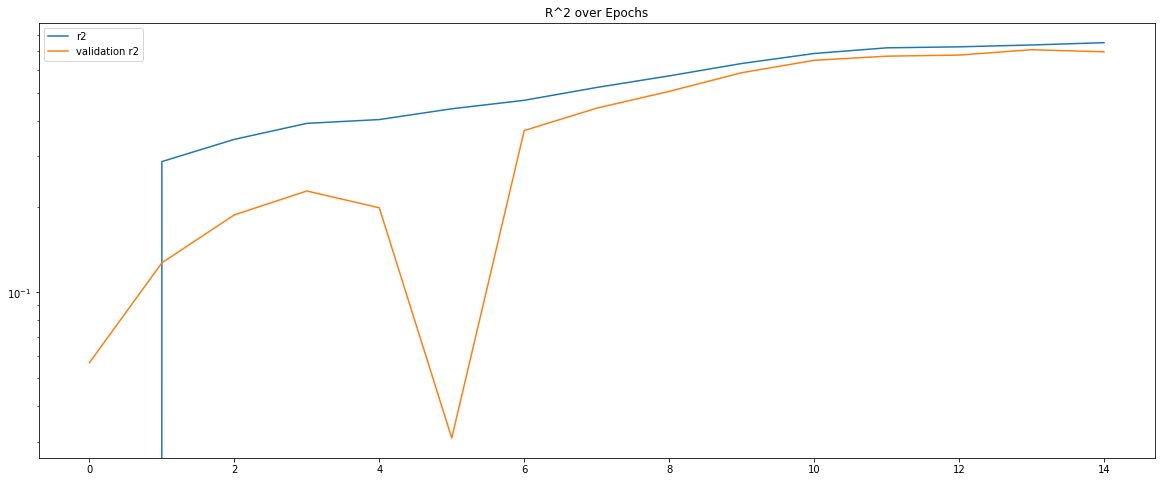

In [24]:
plt.yscale('log')
plt.plot(history.history['r2_metric'])
plt.plot(history.history['val_r2_metric'])
plt.title('R^2 over Epochs')

plt.legend(['r2', 'validation r2']);

In [25]:
model.evaluate(X, Y, batch_size=batch_size, verbose=0)

[6358.173837565331, 0.6834406]

### R2 for all data

In [26]:
from sklearn.metrics import r2_score

Y_pred = model.predict(X)
r2_score(Y, Y_pred)

0.7681316026818664

### R2 for training data

In [27]:
Y_train_pred = model.predict(X_train)
r2_score(Y_train, Y_train_pred)

0.7659642366919346

### R2 for validation data

In [36]:
Y_test_pred = model.predict(X_test)
r2_score(Y_test, Y_test_pred)

0.7713845076818483

## Let's plot predicted and true over each other

In [37]:
Y_pred.shape

(4293, 1)

In [38]:
# for the first 90 days we have no prediction, so get rid of them
consumption[n_steps_in:].shape

(4293,)

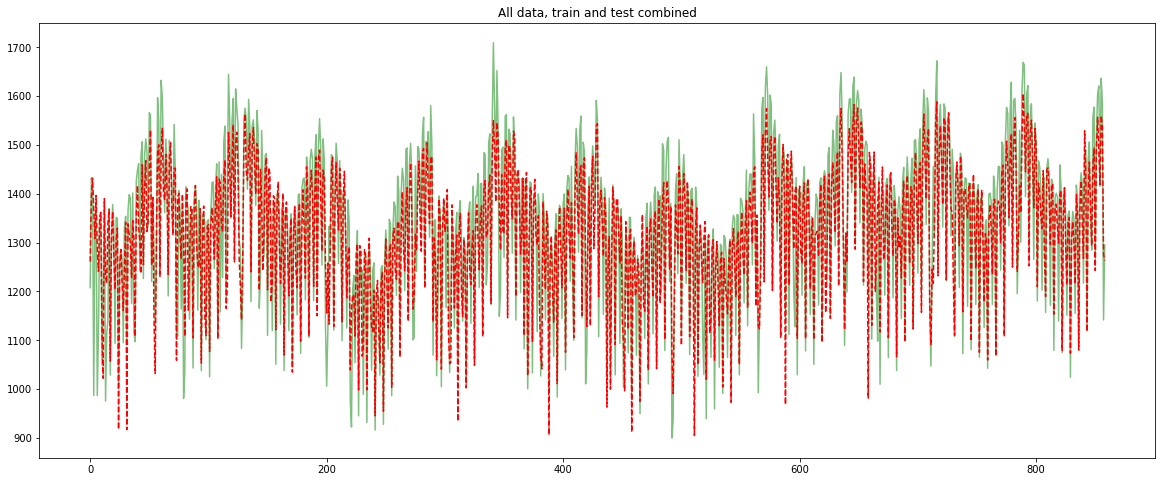

In [39]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(consumption[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred[::stride], color='r', ls='dashed')

plt.title('All data, train and test combined');


In [40]:
Y_test_pred.shape

(365, 1)

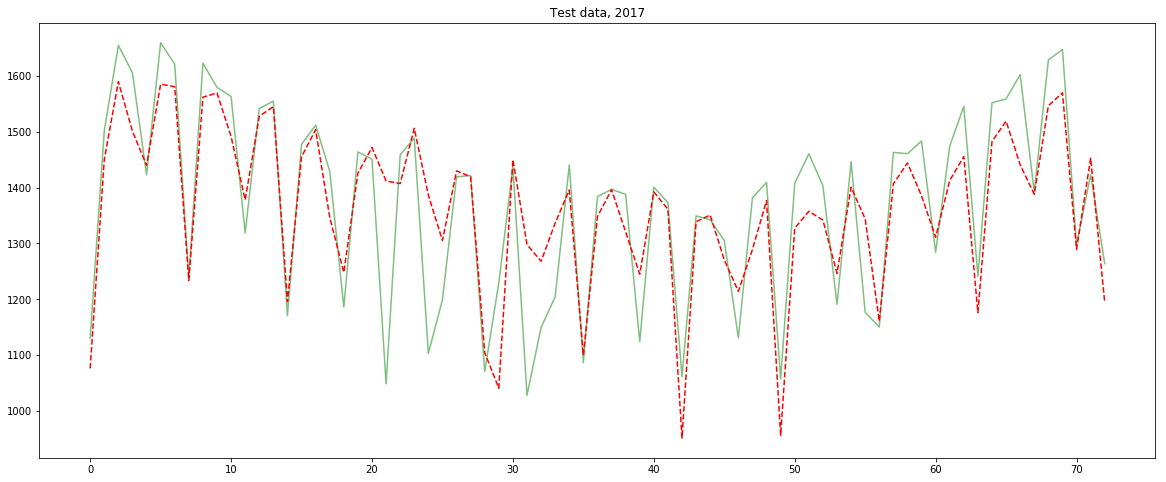

In [41]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(consumption[-365::stride], alpha=0.5, color='g')
plt.plot(Y_test_pred[::stride], color='r', ls='dashed')

plt.title('Test data, 2017');


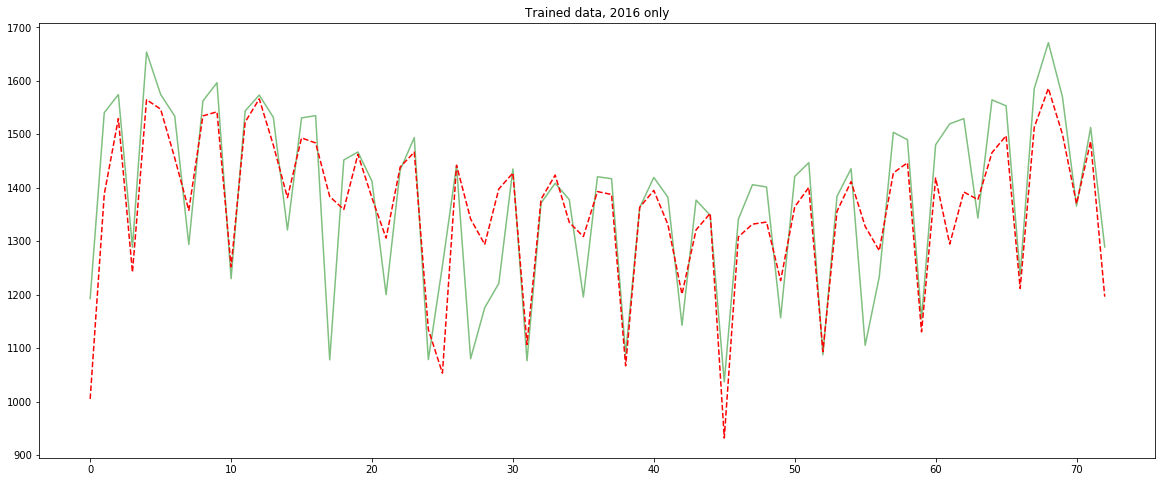

In [42]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(consumption[-2 * 365:-365:stride], alpha=0.5, color='g')
plt.plot(Y_train_pred[-365::stride], color='r', ls='dashed')

plt.title('Trained data, 2016 only');


## Observation

### overall a pretty good result
* r2 score is pretty promising
* loss curve shows the model still is not trained in full

### no dramatic difference between training and test data
* neither in metrices
* nor in visual inspection

###  peaks are almost always underestimated
* this seems to be a common problem in time series prediction
